## Setup
Import modules, define useful functions, and connect Google Drive.

In [ ]:
import os
import sys
import numpy as np
import cv2
import pandas as pd
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import tifffile

import tensorflow as tf
import keras
from keras import layers
from keras import callbacks
from keras.layers import Dense
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# from keras import datasets
from keras.layers import (Dense, Flatten, Dropout, Activation, BatchNormalization,
                          Input, Conv2D, MaxPool2D, Lambda, Conv2DTranspose,
                          concatenate, UpSampling2D, PReLU, LeakyReLU, Add, Cropping2D, ZeroPadding2D)

from keras.models import Model

from IPython.display import clear_output

import sklearn as skl
from sklearn import datasets, linear_model, model_selection
from sklearn.model_selection import train_test_split


In [ ]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();

def display_learning_curves(history):
    # Extract training and validation accuracy values (percentage of correctly classified examples in a validation dataset).
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    # Extract training and validation loss values (quantifies the difference between the model's predictions and the true labels in the validation dataset).
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Define the range of epochs based on the specified 'NUM_EPOCHS'.
    epochs_range = range(num_epochs)

    # Create a figure for plotting.
    fig = plt.figure(figsize=(12, 6))

    # Plot the training and validation accuracy.
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    # Plot the training and validation loss.
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # Adjust the layout and display the figure.
    fig.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data
Import video frames from Google Drive and create Training set, Validation set, and Test set.

In [ ]:
# Unzip the frames
frame_zip_path = "/content/drive/MyDrive/Colab Notebooks/LinesData/LDPad.zip"
frame_extract_dir = "/content"
with zipfile.ZipFile(frame_zip_path, 'r') as zip_ref:
    zip_ref.extractall(frame_extract_dir)

gt_frame_zip_path = "/content/drive/MyDrive/Colab Notebooks/LinesData/GT_LinesData_Pad.zip"
gt_frame_extract_dir = "/content"
with zipfile.ZipFile(gt_frame_zip_path, 'r') as zip_ref:
    zip_ref.extractall(gt_frame_extract_dir)

In [ ]:
# Initialization and choose the ratio for the number of input
frames = []
ratio = 1

startFrame = 1
endFrame = round(53*ratio)

for i in range(startFrame, endFrame):
    frame_path = os.path.join("/content/LDPad/", f'LinesData{i:04d}.tiff')
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    frame = np.expand_dims(frame, axis=-1)
    frames.append(frame)

gt_frames = []
for i in range(startFrame, endFrame):
    gt_frame_path = os.path.join("/content/GT_LinesData_Pad/", f'GT_LinesData_Binary{i:04d}.tiff')
    gt_frame = cv2.imread(gt_frame_path, cv2.IMREAD_GRAYSCALE)
    gt_frame = np.expand_dims(gt_frame, axis=-1)
    gt_frames.append(gt_frame)

# gt_frames = np.clip(gt_frames, 0, 1)
print('Shape of IP Frames: ', frames[0].shape)
print('Shape of GT Frames: ', gt_frames[0].shape)

Shape of IP Frames:  (1080, 1920, 1)
Shape of GT Frames:  (1080, 1920, 1)


In [ ]:
X_combined = np.array(frames)
y_combined = np.array(gt_frames)
X = X_combined.astype('float32')
y = y_combined.astype('float32')

# Split the data into training and temporary sets (80:20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)

# Split the temporary set into validation and test sets (50:50)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

print('X_train', X_train.shape)
print('Y_train', y_train.shape)
print('X_validation', X_validation.shape)
print('Y_validation', y_validation.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)

## U-Net Model Definition
Build the U-Net, compile, and perform the training.

In [ ]:
def unet_model(input_size=(1080, 1920, 1)):
    inputs = Input(input_size)

    inputs = keras.layers.RandomZoom(.5)(inputs)
    inputs = keras.layers.RandomRotation(factor=.5)(inputs)
    inputs = keras.layers.RandomBrightness(factor=.5)(inputs)

    cst_kernel = 5
    cst_dropout = .2

    # Encoder
    conv1 = Conv2D(16, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization(synchronized=True)(conv1)
    pool1 = MaxPool2D(2)(conv1)
    pool1 = Dropout(cst_dropout)(pool1)

    conv2 = Conv2D(32, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization(synchronized=True)(conv2)
    pool2 = MaxPool2D(2)(conv2)
    pool2 = Dropout(cst_dropout)(pool2)

    conv3 = Conv2D(64, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization(synchronized=True)(conv3)
    pool3 = MaxPool2D(2)(conv3)
    pool3 = Dropout(cst_dropout)(pool3)

    # Bottom
    conv4 = Conv2D(128, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(128, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization(synchronized=True)(conv4)
    conv4 = Dropout(cst_dropout)(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(2)(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    conv5 = Conv2D(64, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization(synchronized=True)(conv5)
    conv5 = Dropout(cst_dropout)(conv5)

    up6 = concatenate([UpSampling2D(2)(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(32, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization(synchronized=True)(conv6)
    conv7 = Dropout(cst_dropout)(conv6)

    up7 = concatenate([UpSampling2D(2)(conv6), conv1])
    conv7 = Conv2D(32, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(16, cst_kernel, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization(synchronized=True)(conv7)
    conv7 = Dropout(cst_dropout)(conv7)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Build the U-Net model
model = unet_model()

# Select an optimizer
opt = keras.optimizers.Adam()

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Display the model summary
model.summary()

if (model.count_params() > 3000000):
    raise Exception("Model Too Complex!")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1080, 1920, 1)]      0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 1080, 1920, 16)       416       ['input_4[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 1080, 1920, 32)       12832     ['conv2d_15[1][0]']           
                                                                                                  
 batch_normalization_7 (Bat  (None, 1080, 1920, 32)       128       ['conv2d_16[1][0]']           
 chNormalization)                                                                           

In [ ]:
# # Visualization of the U-Net architecture
# keras.utils.plot_model(model, show_shapes=True)

## Training
Train the model.

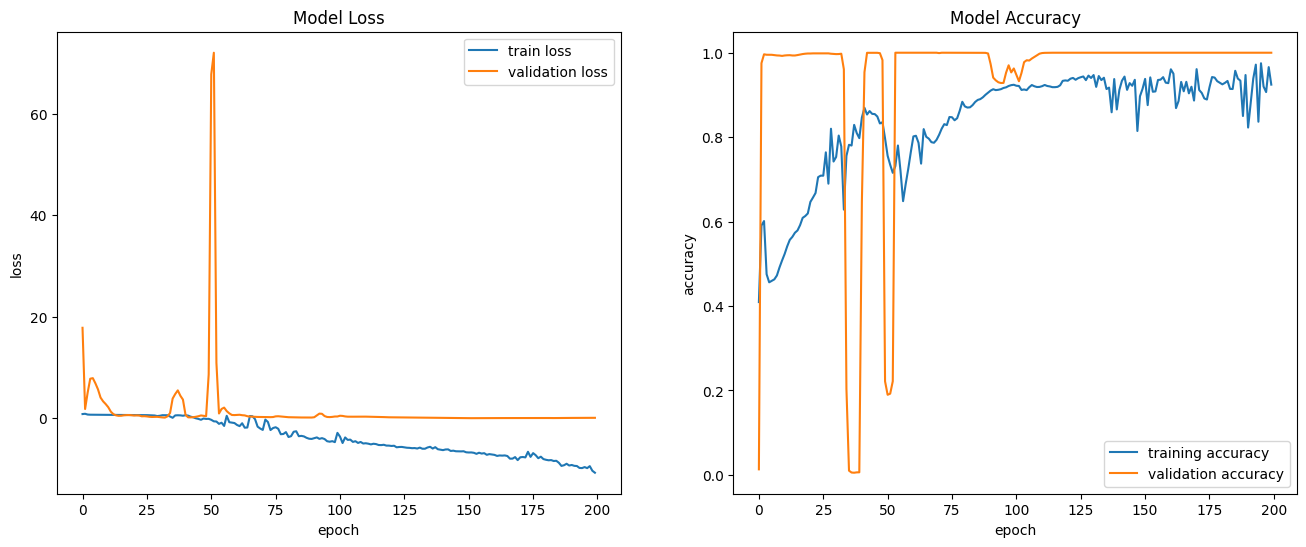

1/1 [==============================] - 1s 919ms/step - loss: -10.7048 - accuracy: 0.9244 - val_loss: 0.1124 - val_accuracy: 1.0000


In [ ]:
num_epochs = 200
pltCallBack = PlotLossAccuracy()

# Run the trianing and store the training history.
model.fit(X_train, y_train,
          batch_size=4,
          epochs=num_epochs,
          validation_data=(X_validation, y_validation),
          callbacks=[pltCallBack])

## Predictions
Use few samples from test dataset to predict using the trained U-Net model.

1/1 [==============================] - 0s 312ms/step


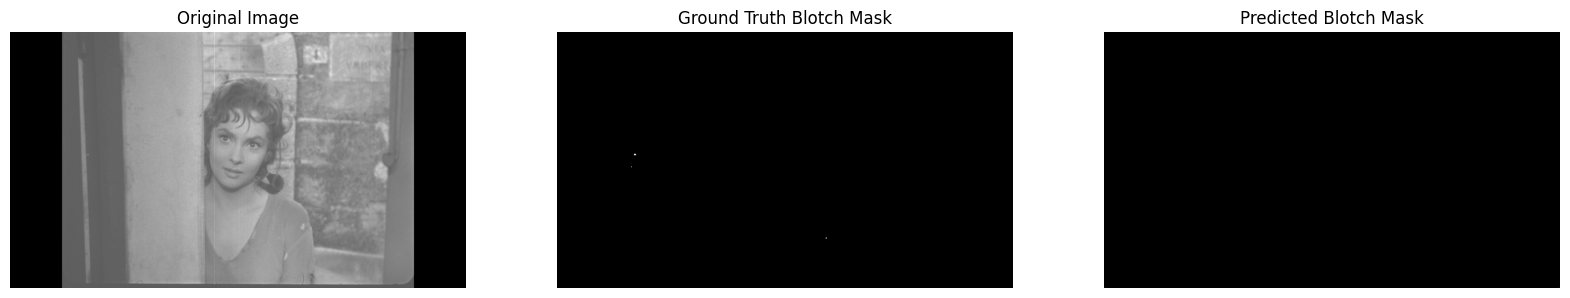

In [ ]:
# Perform inference on test data giving the output probabilities
predictions = model.predict(X_test)

# Apply threshold
threshold = 0.2
predictions = (predictions > threshold).astype(np.uint8)
plt.figure(figsize=(20, 15))

index = 0
# Original Image
plt.subplot(1, 3, 1)
plt.imshow(X_test[index], cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Ground Truth Blotch Mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[index], cmap='gray')
plt.title('Ground Truth Blotch Mask')
plt.axis('off')

# Predicted Blotch Mask
plt.subplot(1, 3, 3)
plt.imshow(predictions[index], cmap='gray')
plt.title('Predicted Blotch Mask')
plt.axis('off')

plt.show()


## Model Saving
Save the trained model in Google Drive (Keras and HDF5)

In [ ]:
version = "LinesDataV1"
subversion = version + "H"

# Save the model as Keras
model.save(f'/content/drive/MyDrive/Colab Notebooks/LinesData/Model Export/{version}/model{subversion}.keras')

# Save the model as HDF5
model.save(f'/content/drive/MyDrive/Colab Notebooks/LinesData/Model Export/{version}/model{subversion}.h5')


## Inference

In [ ]:
imported_model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/LinesData/Model Export/{version}/model{version}.keras')

start_frame = 1
end_frame = 53  # NOT INCLUSIVE

zip_filename = '/content/drive/MyDrive/Colab Notebooks/LinesData/LD_Predictions.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for i in range(start_frame, end_frame):
        # Loading
        frame_path = os.path.join("/content/LDPad/", f'LinesData{i:04d}.tiff')
        frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

        # Preprocessing
        input_frame_normalized = frame.astype('float32')

        # Perform inference on the new data
        prediction = imported_model.predict(np.expand_dims(input_frame_normalized, axis=0))

        # Threshold
        threshold = 0.5
        prediction = (prediction > threshold).astype(np.uint8) * 255

        # Save prediction to TIFF
        prediction_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/LinesData/LD_Predictions/",
                                        f'LD_PredictedMask{i:04d}.tiff')
        cv2.imwrite(prediction_path, prediction[0])

        # Add the prediction file to the zip file
        zipf.write(prediction_path, os.path.basename(prediction_path))

        # Remove the saved prediction after adding it to the zip file
        os.remove(prediction_path)

1/1 [==============================] - 0s 27ms/step
